# Анализ убытков приложения ProcrastinatePRO+

# Описание проекта
Procrastinate Pro+ - развлекательное приложение. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки.
 - Задача:
   - проанализировать эффективность рекламы.
   - сформулировать рекомендации для отдела маркетинга.
 
 
 - Данные — информация пользователях, привлечённых с 1 мая по 27 октября 2019 года:
лог сервера с данными об их посещениях,
выгрузка их покупок за этот период,
рекламные расходы.


Предстоит изучить:
откуда приходят пользователи и какими устройствами они пользуются,
сколько стоит привлечение пользователей из различных рекламных каналов;
сколько денег приносит каждый клиент,
когда расходы на привлечение клиента окупаются,
какие факторы мешают привлечению клиентов.

 - Этапы проекта:
1. Обзор данных
2. Загрузка функций для расчёта и анализа LTV, ROI, удержания и конверсии
3. Исследовательский анализ данных
4. Маркетинг
5. Оценка окупаемости
6. Вывод

### Обзор данных

Загрузим данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`;
- заказы: `/datasets/orders_info_short.csv`;
- расходы: `/datasets/costs_info_short.csv`.

Изучите данные и выполните предобработку. Есть ли в данных пропуски и дубликаты? Убедитесь, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратите внимание на столбцы с датой и временем.

Загрузим библиотеки.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt

Откроем данные.

In [2]:
visits, orders, costs = (
    pd.read_csv('/datasets/visits_info_short.csv'),
    pd.read_csv('/datasets/orders_info_short.csv'),
    pd.read_csv('/datasets/costs_info_short.csv')
)

Сделаем обзор данных.

In [3]:
for a in [visits, orders, costs]:
    display(a.sample())
    display(a.info())
    print(a.duplicated())

,User Id,Region,Device,Channel,Session Start,Session End
29022,92722692368,United States,iPhone,organic,2019-05-30 17:12:35,2019-05-30 17:22:39


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

0         False
1         False
2         False
3         False
4         False
          ...  
309896    False
309897    False
309898    False
309899    False
309900    False
Length: 309901, dtype: bool


,User Id,Event Dt,Revenue
25957,502330160449,2019-10-22 03:13:08,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

0        False
1        False
2        False
3        False
4        False
         ...  
40207    False
40208    False
40209    False
40210    False
40211    False
Length: 40212, dtype: bool


,dt,Channel,costs
452,2019-08-01,RocketSuperAds,6.37


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

0       False
1       False
2       False
3       False
4       False
        ...  
1795    False
1796    False
1797    False
1798    False
1799    False
Length: 1800, dtype: bool


# Описание данных
В распоряжении три датасета. Файл visits_info_short.csv хранит лог сервера с информацией о посещениях сайта, orders_info_short.csv — информацию о заказах, а costs_info_short.csv — информацию о расходах на рекламу.

Структура visits_info_short.csv:
 - User Id — уникальный идентификатор пользователя,
 - Region — страна пользователя,
 - Device — тип устройства пользователя,
 - Channel — идентификатор источника перехода,
 - Session Start — дата и время начала сессии,
 - Session End — дата и время окончания сессии.

Структура orders_info_short.csv:
 - User Id — уникальный идентификатор пользователя,
 - Event Dt — дата и время покупки,
 - Revenue — сумма заказа.

Структура costs_info_short.csv:
 - dt — дата проведения рекламной кампании,
 - Channel — идентификатор рекламного источника,
 - costs — расходы на эту кампанию.
 

В данных отсутствуют дубликаты и пропуски. Но даты имеют неудобный тип данных, а реестр в названиях столбцов разный и есть пробелы - исправим.

In [4]:
for a in [visits, orders, costs]:
    a.columns = [b.lower().replace(' ', '_') for b in a.columns.values]

visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date    

for a in [visits, orders, costs]:
    display(a.sample())
    display(a.info())    

,user_id,region,device,channel,session_start,session_end
257057,136244994072,UK,iPhone,OppleCreativeMedia,2019-08-07 19:15:28,2019-08-07 19:29:13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


None

,user_id,event_dt,revenue
24958,233148069893,2019-10-18 13:12:40,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   40212 non-null  int64         
 1   event_dt  40212 non-null  datetime64[ns]
 2   revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB


None

,dt,channel,costs
1416,2019-10-04,OppleCreativeMedia,16.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

### Загрузка функций для расчёта и анализа LTV, ROI, удержания и конверсии.

Функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

# Функция для создания пользовательских профилей

In [5]:
def get_profiles(sessions, orders, ad_costs):
    # Шаг 1. Передадим в функцию расчета профиля данные о рекламных затратах (фрейм ad_costs)
    

    # сортируем сессии по id пользователя и дате для того,чтобы работал first
    # находим первые значения для параметров пользователя - будем считать их основными 
    profiles = (sessions.sort_values(by = ['user_id', 'session_start'])           
                        .groupby('user_id').agg({'session_start' : 'first',       
                                                 'channel': 'first',
                                                 'device': 'first',
                                                 'region': 'first'})                                 
                        .rename(columns = {'session_start' : 'first_ts'})  
                        .reset_index()  # вернем все данные из индекса в колонки                                           
               )
    # определим дату первого посещеня 
    # и начало месяца первого посещения - они понадобятся нам при когортном анализе
    profiles['dt'] = profiles['first_ts'].dt.date                                 
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')     
    

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())   
            

    # Шаг 2. К данным о рекламных затратах добавим количества привлеченных пользователей
    new_users = profiles.groupby(['dt', 'channel']).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'unique_users'}).reset_index()
    ad_costs = ad_costs.merge(new_users, on = ['dt', 'channel'], how = 'left')
    

    # Шаг 3. Найдем среднюю стоимость привлечения пользователя
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    

    # Шаг 4. Присоединим данные к профилям пользователей информацию о средней стоимости привлечения в день привлечения пользователя из нужного источника
    profiles = profiles.merge(ad_costs[['dt', 'channel', 'acquisition_cost']], on = ['dt', 'channel'], how = 'left')
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0) # органические пользователи будут стоить 0
    

    return profiles

# Функция для расчёта удержания

In [6]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

# Функция для расчёта конверсии

In [7]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

# Функция для расчёта LTV и ROI

In [8]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

# Функция для сглаживания фрейма

In [9]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

# Функция для визуализации удержания

In [10]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

# Функция для визуализации конверсии

In [11]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

# Функция для визуализации LTV и ROI

In [12]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Исследовательский анализ данных

- Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.
- Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.


In [13]:
profiles = get_profiles(visits, orders, costs)
display(profiles.head(5))
print("Минимальная дата привлечения пользователей:", profiles['first_ts'].dt.date.min())
print("Максимальная дата привлечения пользователей:", profiles['first_ts'].dt.date.max())

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-27


Данные соответствуют описанию лога с сервера, минимальная дата привлечения 1 мая 2019 года.

In [14]:
profiles_t = profiles.query('payer == True').groupby('region').agg({'payer':'count'}).sort_values(by = 'payer', ascending = False)
profiles_p = profiles.groupby('region').agg({'payer':'count'}).sort_values(by = 'payer', ascending = False)
profiles_s = profiles_p.merge(profiles_t, on='region', how = 'left').rename(columns={'payer_x': 'count_user', 'payer_y': 'paying_user'})
profiles_s['rate_percent'] = (profiles_s['paying_user']/profiles_s['count_user']*100).round(decimals=2)
display(profiles_s)

,count_user,paying_user,rate_percent
region,,,
United States,100002,6902,6.90
UK,17575,700,3.98
France,17450,663,3.80
Germany,14981,616,4.11


Пользователи приходят в приложение из четырёх стран: США, Англия, Франция, Германия. Пользователей из США почти в шесть раз больше, чем из любой другой страны списка. Платящих пользователей из США примерно в десять раз больше, чем платящих пользователей любой из этих стран.

In [15]:
profiles_t = profiles.query('payer == True').groupby('device').agg({'payer':'count'}).sort_values(by = 'payer', ascending = False)
profiles_p = profiles.groupby('device').agg({'payer':'count'}).sort_values(by = 'payer', ascending = False)
profiles_s = profiles_p.merge(profiles_t, on='device', how = 'left').rename(columns={'payer_x': 'count_user', 'payer_y': 'paying_user'})
profiles_s['rate_percent'] = (profiles_s['paying_user']/profiles_s['count_user']*100).round(decimals=2)
display(profiles_s)

,count_user,paying_user,rate_percent
device,,,
iPhone,54479,3382,6.21
Android,35032,2050,5.85
PC,30455,1537,5.05
Mac,30042,1912,6.36


Пользователи используют следующие девайсы: iPhone, Android, PC, Mac. iPhone лидирует с существенным отрывом в почти двадцать тысяч девайсов относительно Android. Далее следуют PC и Mac. Платящие пользователи предпочитают iPhone, далее Android, PC, Mac по убыванию.

In [16]:
profiles_t = profiles.query('payer == True').groupby('channel').agg({'payer':'count'}).sort_values(by = 'payer', ascending = False)
profiles_p = profiles.groupby('channel').agg({'payer':'count'}).sort_values(by = 'payer', ascending = False)
profiles_s = profiles_p.merge(profiles_t, on='channel', how = 'left').rename(columns={'payer_x': 'count_user', 'payer_y': 'paying_user'})
profiles_s['rate_percent'] = (profiles_s['paying_user']/profiles_s['count_user']*100).round(decimals=2)
display(profiles_s.sort_values(by = 'paying_user', ascending = False))

,count_user,paying_user,rate_percent
channel,,,
FaceBoom,29144,3557,12.20
TipTop,19561,1878,9.60
organic,56439,1160,2.06
WahooNetBanner,8553,453,5.30
AdNonSense,3880,440,11.34
RocketSuperAds,4448,352,7.91
LeapBob,8553,262,3.06
OppleCreativeMedia,8605,233,2.71
lambdaMediaAds,2149,225,10.47


Органических пользователей больше всего: 56439. Но процент платящих пользователей, пришедших по этому каналу, самый низкий - всего 2.06. Самым интересным выглядит канал привлечения FaceBoom: 29144 пользователя из которых более 12 процентов платящих.

# Общий вывод:
 - основными пользователями являются жители США.
 - самое популярный девайс - iPhone
 - 11 каналов привлечения

### Маркетинг

- Посчитаем общую сумму расходов на маркетинг.
- Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. 
- Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используем профили пользователей.


In [17]:
print('Общая сумма расходов на маркетинг:', costs['costs'].sum().round(1))

Общая сумма расходов на маркетинг: 105497.3


,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


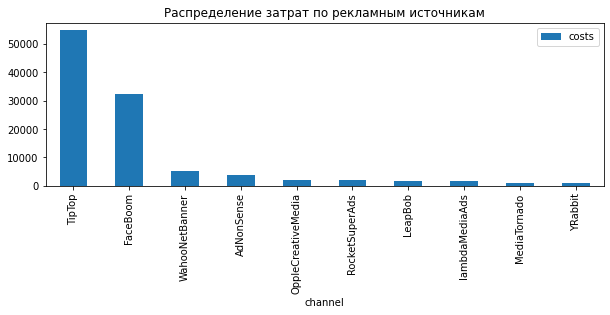

In [18]:
costs_per_channel = costs.groupby('channel').agg({'costs': 'sum'}).sort_values(by = 'costs', ascending = False)
display(costs_per_channel)
costs_per_channel.plot.bar(figsize = (10,3))
plt.title('Распределение затрат по рекламным источникам')
plt.show()

Можно выделить два основных канала: TipTop и FaceBoom. Именно на эти источники пришлась большая часть трат 54751 и 32445 соответственно. Это более 80% всего бюджета.

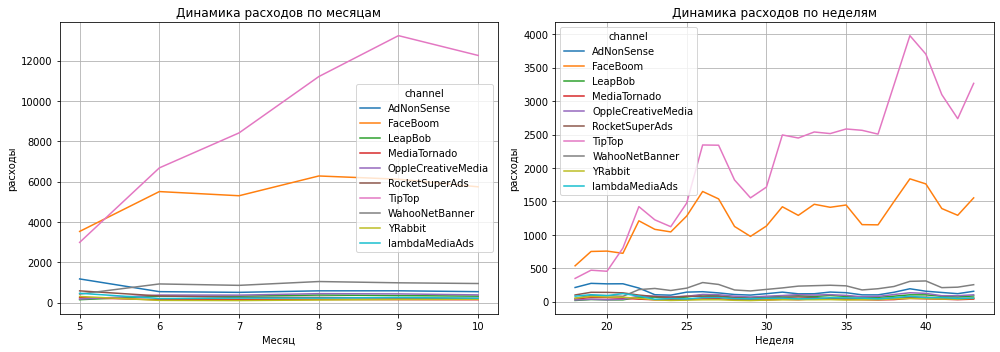

In [19]:
costs_p = costs
costs_p['month'] = pd.to_datetime(costs['dt']).dt.month
costs_p['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week

plt.figure(figsize=(14, 5))
ax1 = plt.subplot(1, 2, 1)
costs_p.pivot_table(
    index='month', columns='channel', values='costs', aggfunc='sum'
).plot(grid=True, ax=ax1)
plt.ylabel('расходы')
plt.xlabel('Месяц')
plt.title('Динамика расходов по месяцам')

ax2 = plt.subplot(1, 2, 2)
costs_p.pivot_table(
    index='week', columns='channel', values='costs', aggfunc='sum'
).plot(grid=True, ax=ax2)
plt.ylabel('расходы')
plt.xlabel('Неделя')
plt.title('Динамика расходов по неделям')

plt.tight_layout()
plt.show()

График расходов по месяцам показывает плавный рост динамики. У канала привлечения TipTop виден пик в сентябре. Если смотреть по неделям график уже не такой плавный: видны всплески. Особенно можно выделить пик после 25-й недели и перед 40-й неделей. Но пиковые значения приходятся тоже примерно на сентябрь.

In [20]:
profiles_cac = profiles[(profiles['payer'] == True) & (profiles['channel'] != 'organic')].pivot_table(
    index=['channel'], values='acquisition_cost', aggfunc='mean').sort_values(by = 'acquisition_cost', ascending = False).round(2)
display(profiles_cac)
print("Средний САС:", profiles_cac['acquisition_cost'].mean().round(2))

,acquisition_cost
channel,
TipTop,2.79
FaceBoom,1.11
AdNonSense,1.01
lambdaMediaAds,0.74
WahooNetBanner,0.60
RocketSuperAds,0.42
OppleCreativeMedia,0.25
MediaTornado,0.22
YRabbit,0.21


Средний САС: 0.76


TipTop снова лидирует - 2.78. Средняя стоимость привлечения одного пользователя по этому каналу более чем в два раза превышает этот показатель у канала FaceBoom. AdNonSense и FaceBoom идут рядом, 1.01 и 1.11. Далее стоимость убывает, в самом хвосте - LeapBob с 0.21.

### Оценим окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. Будем считать, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения.

- Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучите графики конверсии и удержания.
- Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Ответим на вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?


In [21]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14
profiles = profiles.query('channel != "organic"')

Зададим момент и горизонт анализа данных. Нам известно, что в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. 
Исключим из анализа пользователей которые пришли по органическому каналу, так как условные затраты на них не релевантны текущей задаче.

Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.

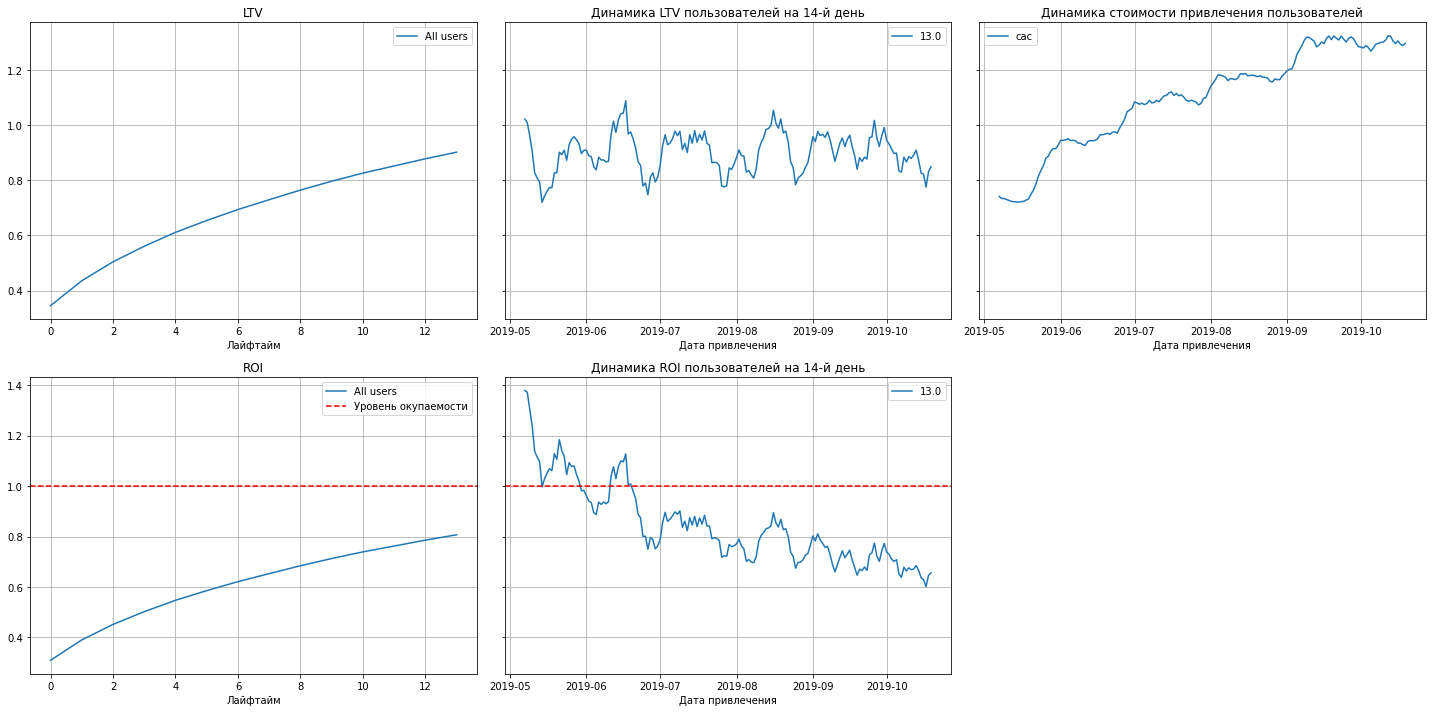

In [22]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Из графиков следует:
- К концу двух недель ROI ниже уровня 80%. Реклама не окупается.
- CAC имеет постоянный неравномерный рост, то есть рекламные кампании проходят регулярно.
- LTV находится в стабильном диапазоне. Значит, качество пользователей примерно одинаковое.


Перейдём к более детальному анализу.
Посмотрим на конверсию разбив по каналам.

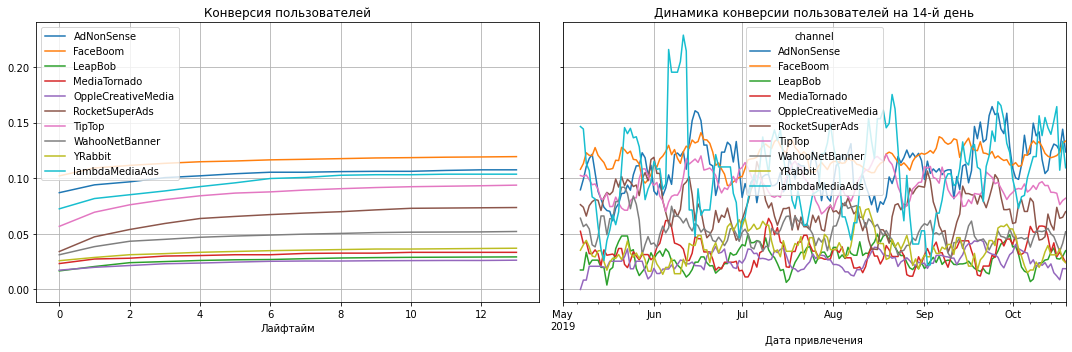

In [23]:
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)
plot_conversion(conversion_grouped, conversion_history, horizon_days)

Графики показывают достаточно стабильную конверсию. Посмотрим на каналы "съедающие" большую часть бюджета - FaceBoom и TipTop. 

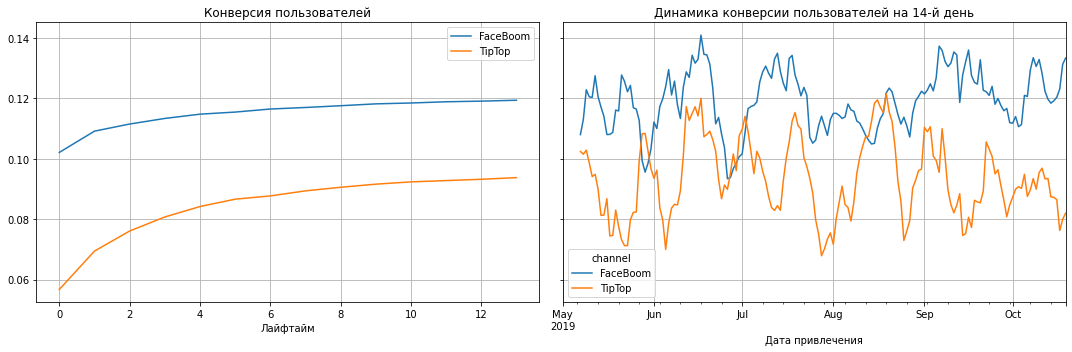

In [24]:
top_channel = ['FaceBoom', 'TipTop']
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles.query('channel in @top_channel'), orders, observation_date, horizon_days, dimensions=dimensions
)
plot_conversion(conversion_grouped, conversion_history, horizon_days)

FaceBoom стоит дешевле, а конвертируется лучше чем TipTop. Посмотрим на удержание.

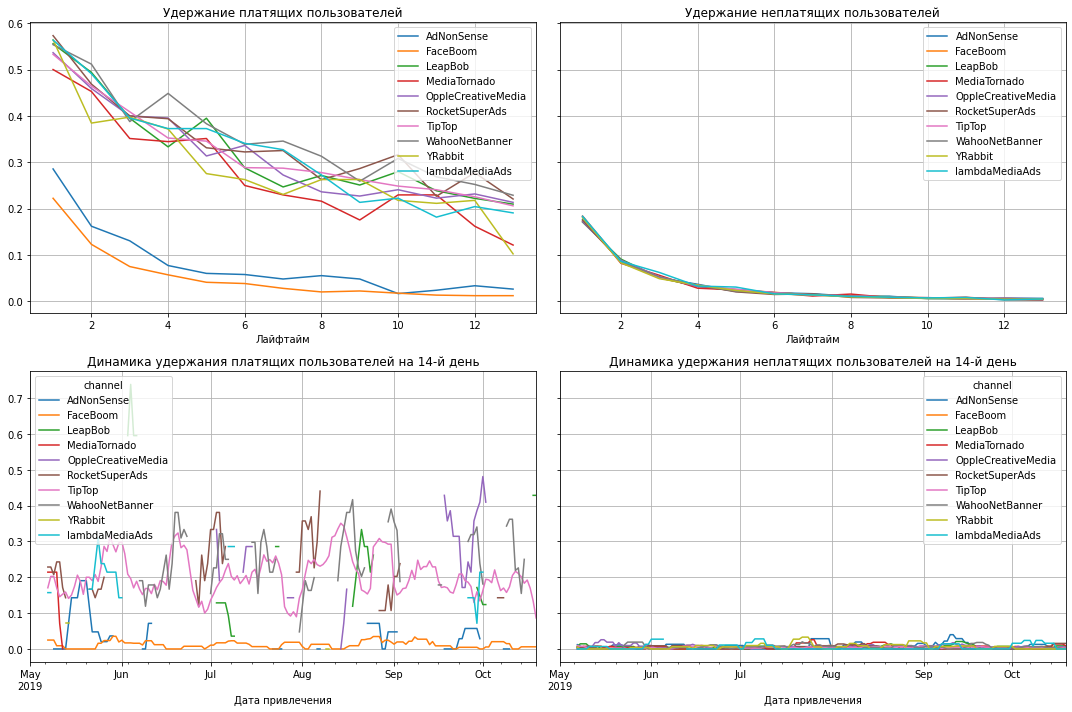

In [25]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Удержание неплатящих пользователей выглядит стабильно безрадостно, что логично. С платящими пользователями картина более интересная. FaceBoom и AdNonSense слабо удерживают пользователей - к 14-му дню цифры близки к нулю. А остальные каналы, среди которых и ненасытный TipTop, имеют достаточно похожие показатели в районе 20%.

Проанализируем удержание с разбивкой по устройствам и регионам.

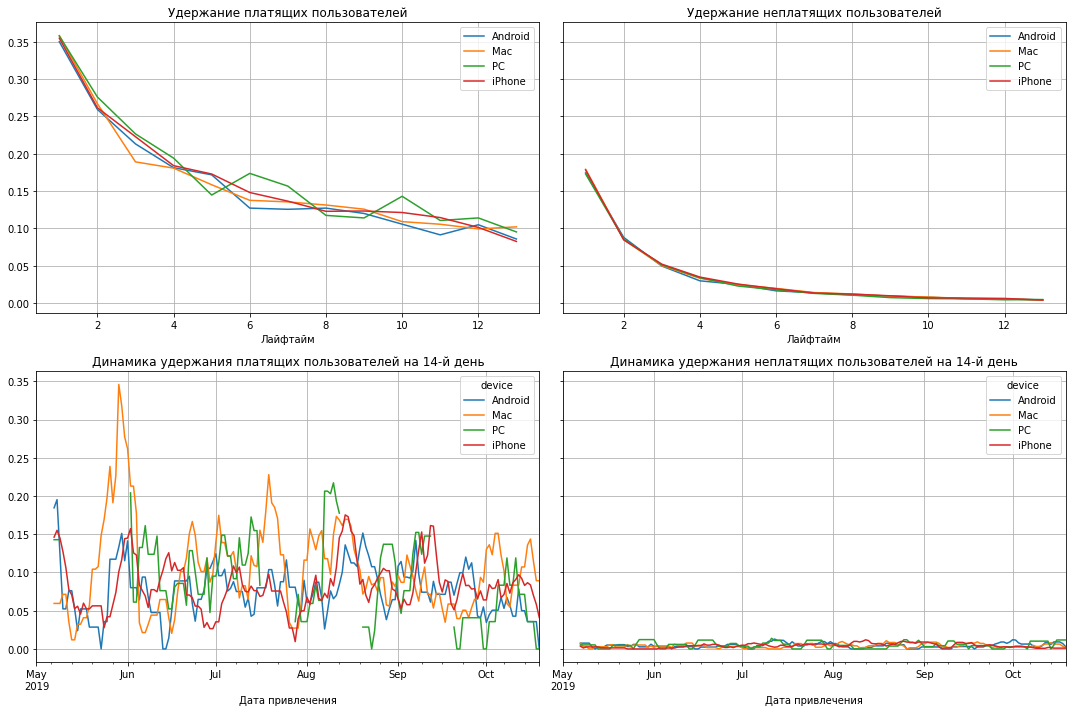

In [26]:
region_us = ['United States']
dimensions = ['device']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles.query('region in @region_us'), visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

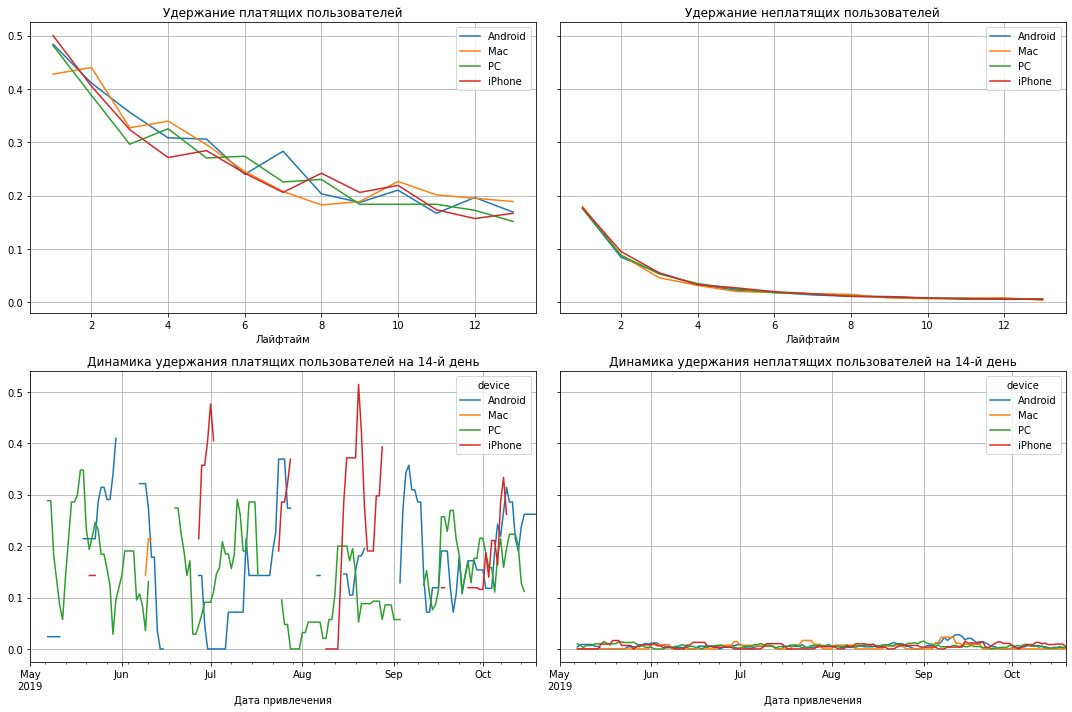

In [27]:
region_us = ['United States']
dimensions = ['device']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles.query('region not in @region_us'), visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Разницы по устройствам существенной нет, показатели удержания находятся в одном диапазоне. К концу второй недели в США около 10% , в Европейских странах показатель выше: около 20%.

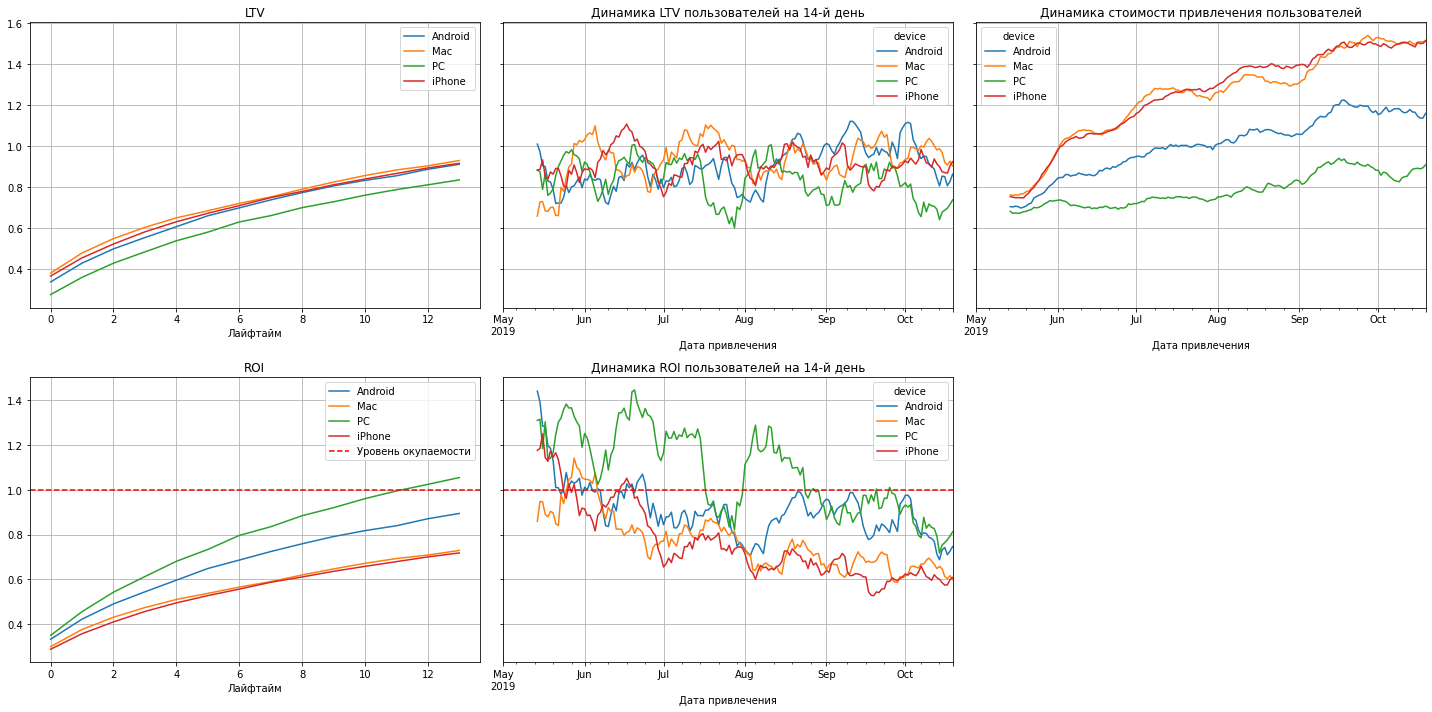

In [28]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Окупаются только пользователи PC. Стоимость привлечения стабильно растёт, самый низкий показатель у пользователей PC, как и показатель LTV. Динамика ROI даёт не очень хорошую картину в сентябре. Окупаемость по iPhone и Mac выглядит хуже всего. 
Посмотрим, есть ли влияние при разбивке по устройствам, в США и Европейских странах отдельно.

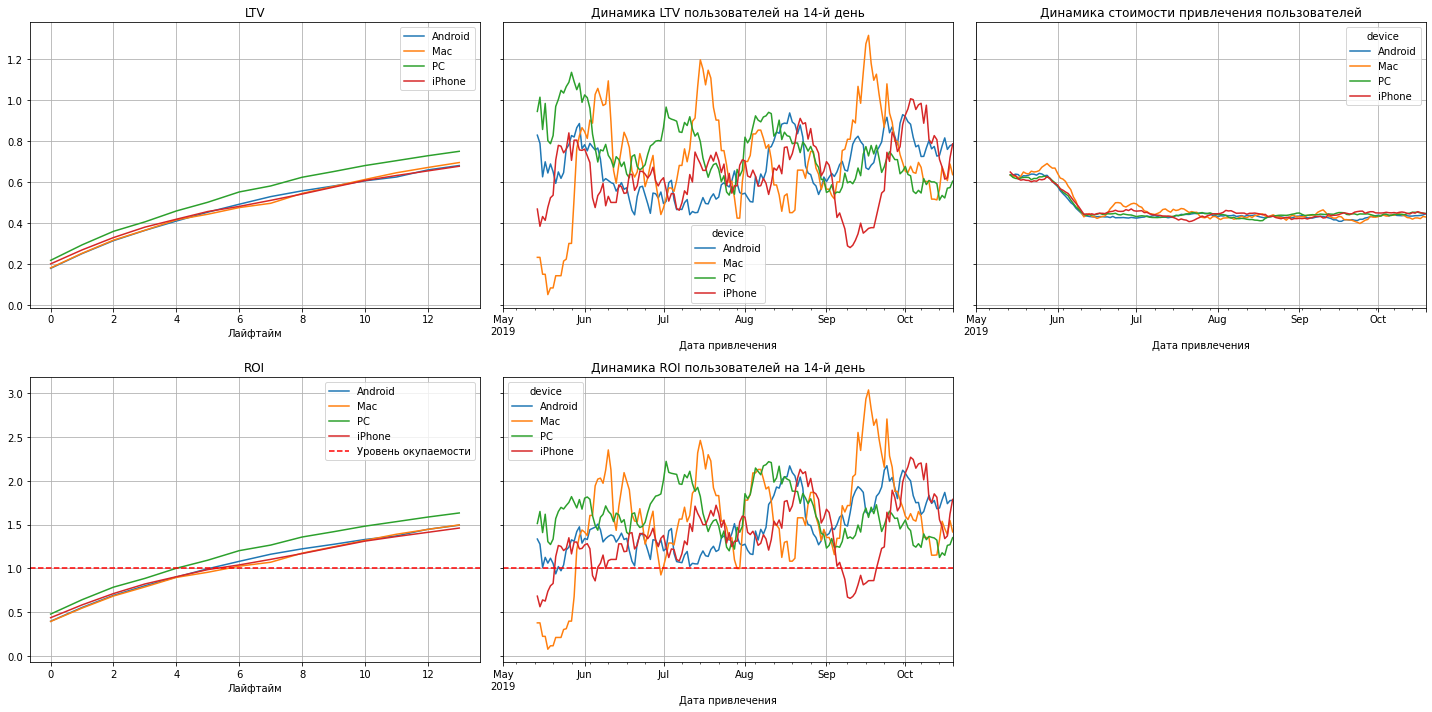

In [29]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('region not in @region_us'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

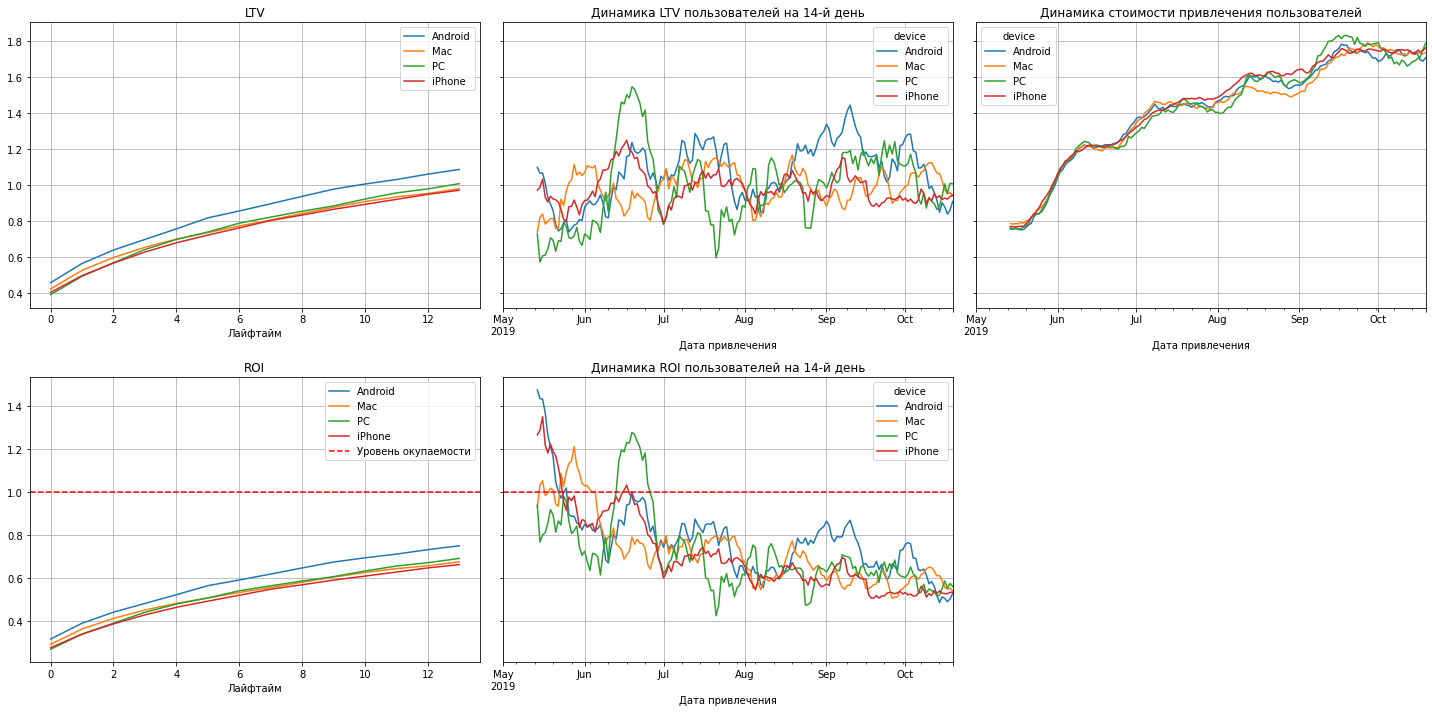

In [30]:
region_us = ['United States']
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('region in @region_us'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

На фоне США в Европе всё достаточно хорошо, все каналы окупаются, чего нельзя сказать о стране где почти в шесть раз больше пользователей, чем в любой другой страны списка. ROI имеет не сильный разброс в показателях по каналам.

Проанализируем окупаемость рекламы с разбивкой по странам.

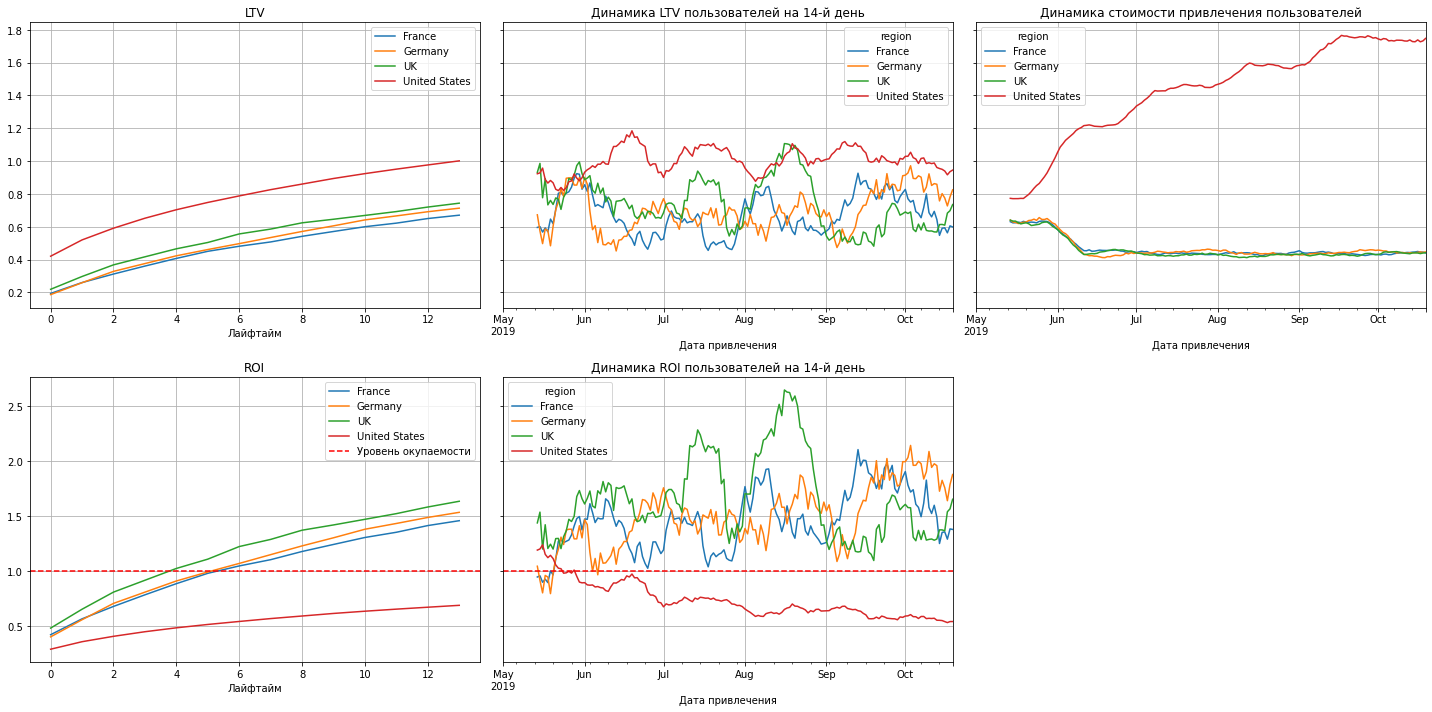

In [31]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Реклама окупается везде кроме США. Даже при самом высоком LTV среди прочих стран, высокая стоимость привлечения пользователей не даёт шансов увидеть хорошие показатели ROI.

Посмотрим окупаемость рекламы с разбивкой по рекламным каналам.

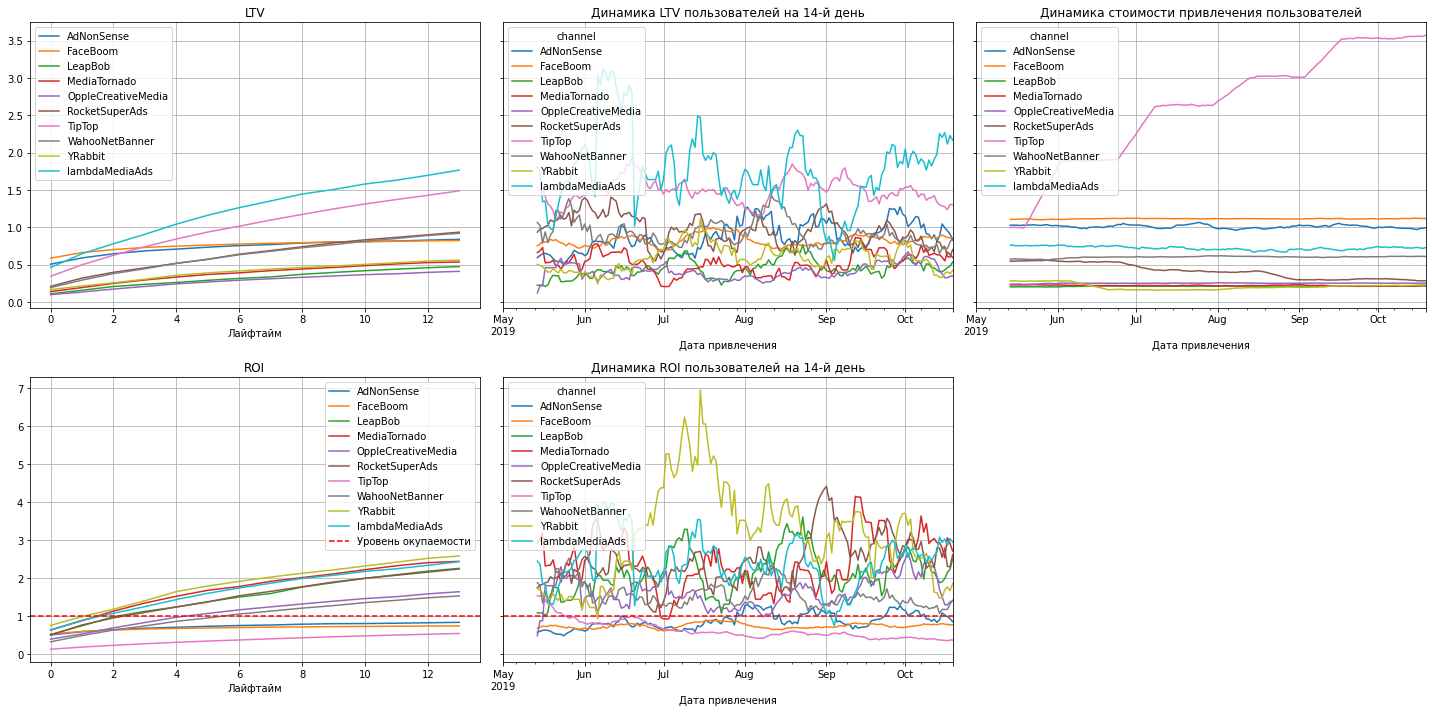

In [32]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Окупаются все каналы кроме AdNonSense, FaceBoom и TipTop. Стоимость привлечения у этих каналов выше чем LTV. У канала TipTop систематический серьёзный рост показателей CAC. У остальных каналов динамика стоимости привлечения показывает стабильную картину.
Посмотрим окупаемость по каналам привлечения по одной стране. Нам уже известно, что самый низкий ROI у США, и реклама не окупается только там.

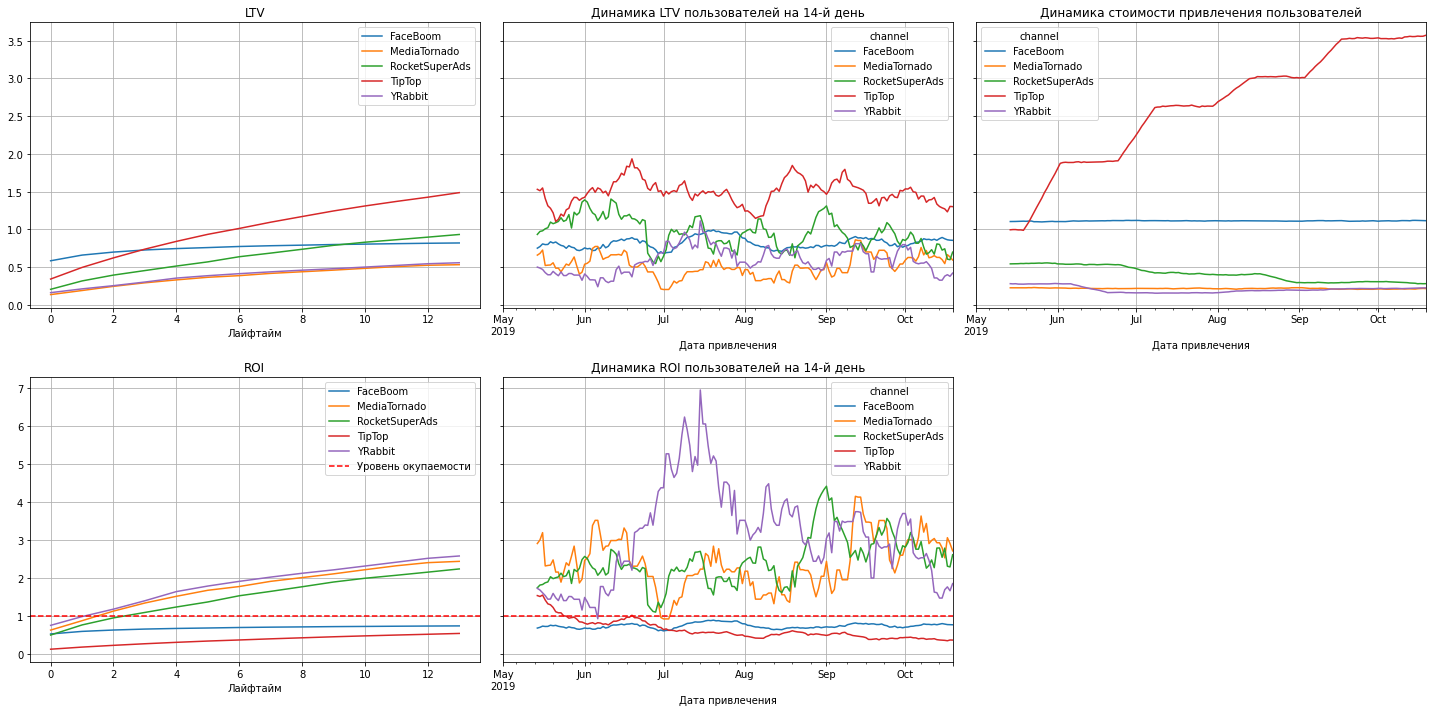

In [33]:
region_us = ['United States']
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('region in @region_us'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

FaceBoom и TipTop не окупаются, а остальные каналы окупаются уже на 2-3 день. LTV стабилен. Стоимость привлечения у TipTop циклично растёт.
Посмотрим какие каналы окупаются в остальных странах.

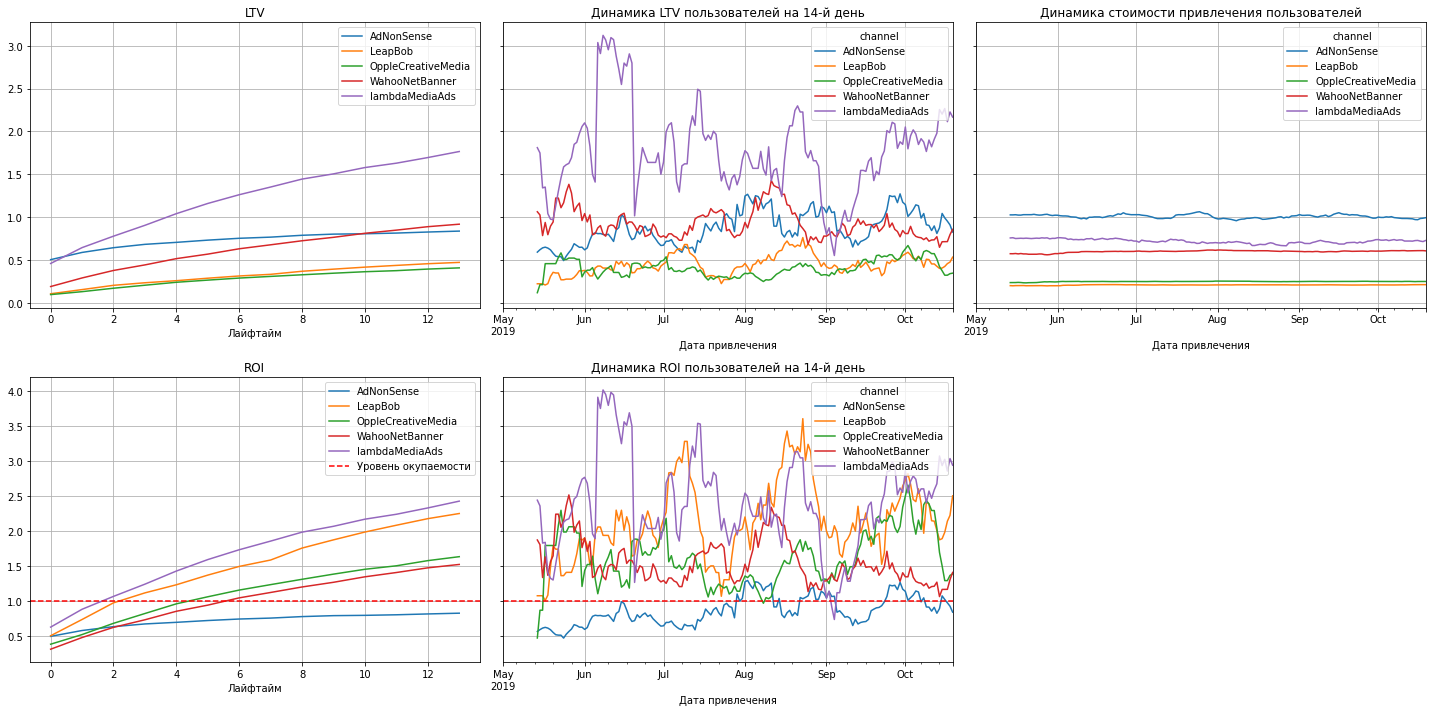

In [34]:
region_us = ['United States']
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('region not in @region_us'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

В европейских странах неэффективно бюджет "съедается" каналом AdNonSense, стоимость привлечения самая высокая в то время как ROI низкий и канал не окупается. Остальные каналы показывают стабильные показатели CAC, неплохой ROI и окупаемость.

#  Вывод:

Пользователей из США подавляющее большинство, а платящих пользователей - в три раза больше чем из остальных стран вместе взятых. 

Более 80% бюджета расходуется на каналы из США: FaceBoom и TipTop. Оба канала не окупаются. При лучшей конверсии среди прочих каналов, FaceBoom имеет самые худшие показатели удержания пользователей. Канал TipTop имеет примерно такие же показатели удержания как и остальных каналов. Но при LTV 1.5 средняя CAC у TipTop 2.79. И это в несколько раз выше, чем у остальных каналов и показатель растёт из раза в раз. Как итог низкий ROI.

В европе единственным неокупающимся каналом является AdNonSense. При неплохой конверсии в 10%, что является вторым показателем среди всех каналов, очень низкий процент удержания. LTV ниже CAC, как итог низкий ROI.

Реккомендации:
Тщательно проработать рекламный бюджет с учётом проведённого исследования и перераспределить расход в пользу более привлекательных каналов: lambdaMediaAds и LeapBob в Европе и RocketSuperAds в США.
YRabbit, MediaTornado имеют низкую конвертируемость и сильно падающее удержание на последних днях горизонта. Нужно более подробно исследовать данные по этим каналам с большим количеством информации.